In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import models
from torchvision import transforms as tf
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [2]:
squeezenet = models.squeezenet1_0(weights=True).features

for param in squeezenet.parameters():
    param.requires_grad_(False) # freezing all parameters or weights


/home/vaibhav/Desktop/Coding/HowToPython/.venv1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

squeezenet.to(device)


Sequential(
  (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): Fire(
    (squeeze): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
   

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)
print()


if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('    Total:', round(torch.cuda.get_device_properties(0).total_memory/1024**3, 4), 'GB')
    print('    Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 4), 'GB')
    print('    Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 4), 'GB')

Using device:  cuda

NVIDIA GeForce GTX 1650
Memory Usage:
    Total: 3.8124 GB
    Allocated: 0.0027 GB
    Cached:    0.0039 GB


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225) #The mean and std values are of the image dataset on which the model was trained on(Imagenet).

def transformation(img):

    tasks = tf.Compose([tf.Resize(512), tf.ToTensor(), tf.Normalize(mean, std)])
    img = tasks(img)  
    img = img.unsqueeze(0)    

    return img


In [11]:
content_img = Image.open("input_image_2.jpg").convert('RGB')
style_img   = Image.open("style_image_1.jpg").convert('RGB')


In [12]:
content_img = transformation(content_img).to(device)
style_img   = transformation(style_img).to(device)


In [13]:
def tensor_to_image(tensor):

    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()

    image = image.transpose(1, 2, 0)

    image *= np.array(std) + np.array(mean)
    image = image.clip(0, 1)

    return image


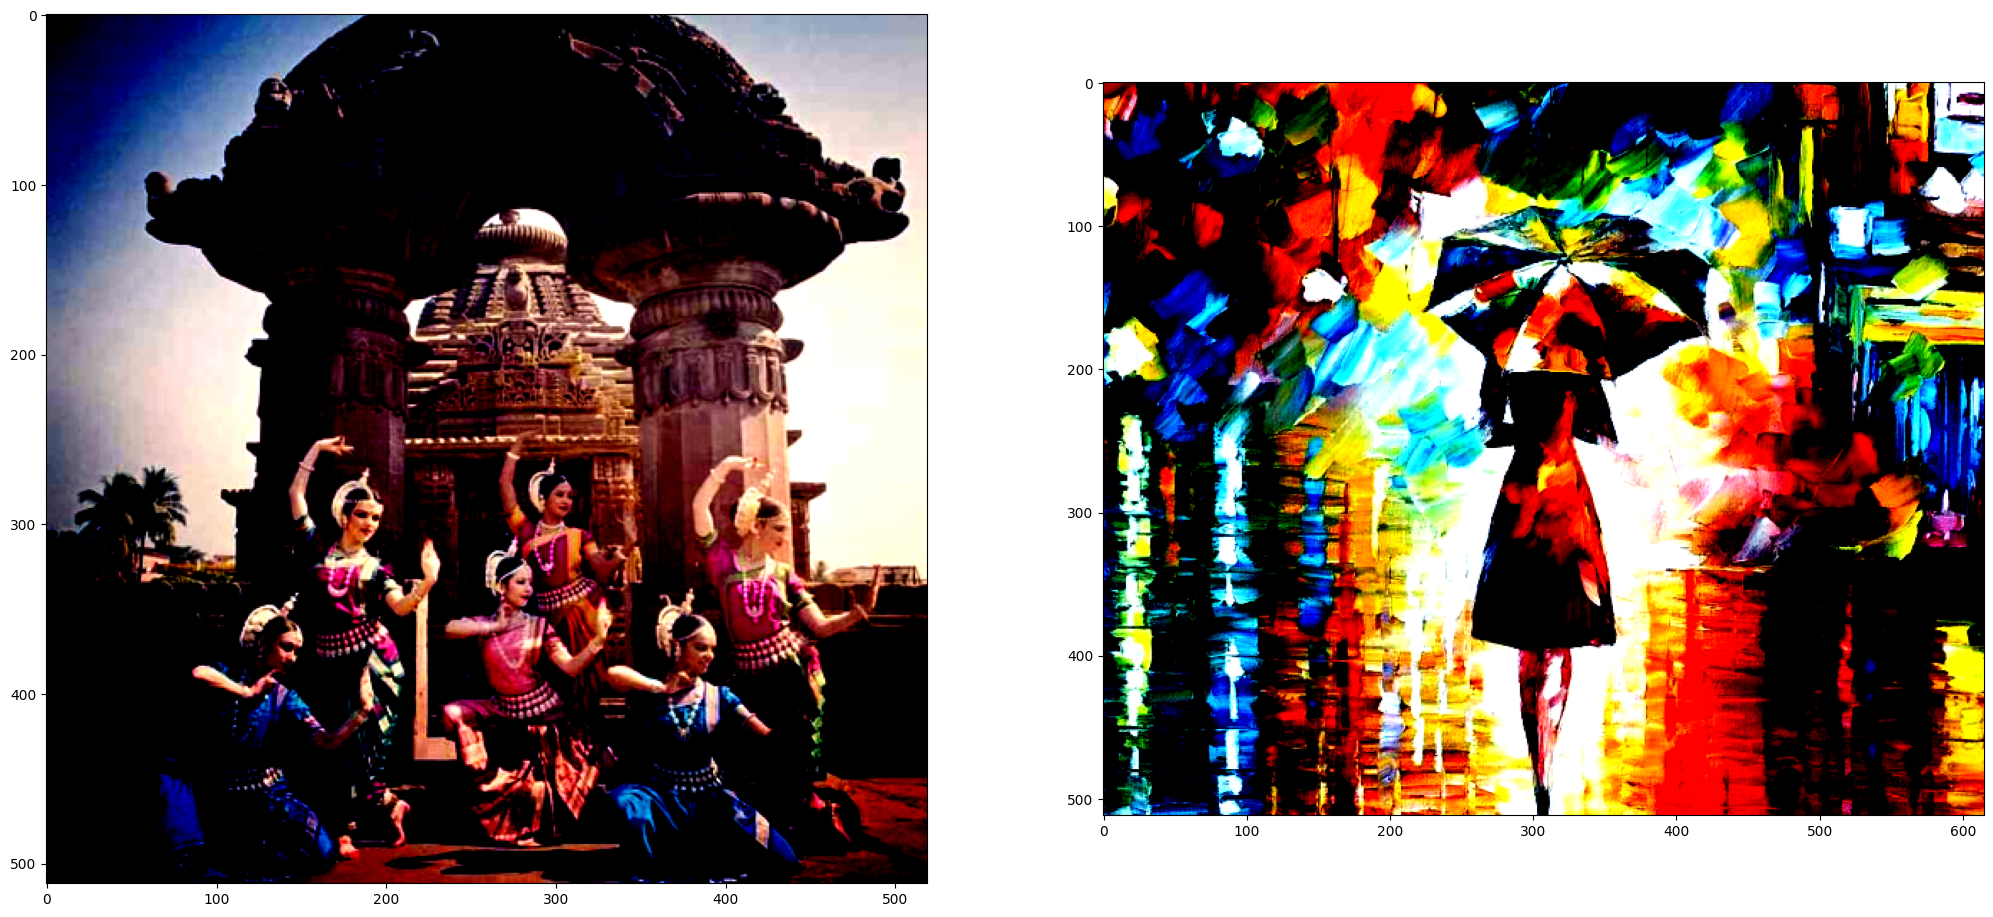

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(style_img))

In [15]:
# img = tensor_to_image(content_img)
# fig = plt.figure()
# fig.suptitle('Content Image')
# plt.imshow(img)

# img = tensor_to_image(style_img)
# fig = plt.figure()
# fig.suptitle('Style Image')
# plt.imshow(img)


In [16]:
LAYERS_OF_INTEREST = {
    '0': 'conv1_1', 
    '3': 'conv2_1',  
    '4': 'conv3_1',
    '5': 'conv4_1',
    '6': 'conv5_1',
    '7': 'conv6_1',  
    '8': 'conv7_1',
    '9': 'conv8_1'
}


In [17]:

def apply_model_and_extract_features(image, model):
    x = image

    features = {}

    for name, layer in model._modules.items():
        x = layer(x)

        if name in LAYERS_OF_INTEREST:
            features[LAYERS_OF_INTEREST[name]] = x   

    return features


In [18]:
content_img_features = apply_model_and_extract_features(content_img, squeezenet)
style_img_features   = apply_model_and_extract_features(style_img, squeezenet)


In [19]:
def calculate_gram_matrix(tensor):

    _, channels, height, width = tensor.size()

    tensor = tensor.view(channels, height * width)    

    gram_matrix = torch.mm(tensor, tensor.t())

    gram_matrix = gram_matrix.div(channels * height * width) 

    return gram_matrix


In [20]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in 
                                                    style_img_features}

style_features_gram_matrix


{'conv1_1': tensor([[2.0226e-03, 9.2931e-04, 6.5679e-04,  ..., 7.4648e-04, 1.5820e-03,
          1.1710e-03],
         [9.2931e-04, 7.8560e-03, 1.2780e-03,  ..., 1.0574e-03, 6.1695e-03,
          1.5276e-03],
         [6.5679e-04, 1.2780e-03, 3.8214e-03,  ..., 6.9633e-04, 2.5401e-03,
          1.7918e-03],
         ...,
         [7.4648e-04, 1.0574e-03, 6.9633e-04,  ..., 3.9879e-03, 2.9006e-03,
          3.6147e-05],
         [1.5820e-03, 6.1695e-03, 2.5401e-03,  ..., 2.9006e-03, 1.6305e-02,
          2.3293e-03],
         [1.1710e-03, 1.5276e-03, 1.7918e-03,  ..., 3.6147e-05, 2.3293e-03,
          1.2497e-02]], device='cuda:0'),
 'conv2_1': tensor([[0.0041, 0.0023, 0.0030,  ..., 0.0054, 0.0002, 0.0091],
         [0.0023, 0.1101, 0.0255,  ..., 0.0175, 0.0002, 0.0368],
         [0.0030, 0.0255, 0.0622,  ..., 0.0182, 0.0003, 0.0342],
         ...,
         [0.0054, 0.0175, 0.0182,  ..., 0.0451, 0.0007, 0.0483],
         [0.0002, 0.0002, 0.0003,  ..., 0.0007, 0.0007, 0.0009],
         [0.

In [21]:
weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.65,
           'conv4_1': 0.5, 'conv5_1': 0.45, 'conv6_1': 0.3, 
           'conv7_1': 0.1, 'conv8_1': 0.15}

target = content_img.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([target], lr=0.003)


In [22]:
epochs = 2000

In [ ]:
for i in tqdm(range(epochs), total=epochs, unit="epochs"):

    target_features = apply_model_and_extract_features(target, squeezenet)
    content_loss = F.mse_loss (target_features['conv7_1'], content_img_features['conv7_1'])

    style_loss = 0

    for layer in weights:

        target_feature = target_features[layer]

        target_gram_matrix = calculate_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]

        layer_loss = F.mse_loss (target_gram_matrix, style_gram_matrix)
        layer_loss *= weights[layer]

        _, channels, height, width = target_feature.shape

        style_loss += layer_loss  

    total_loss = 1000000 * style_loss + content_loss

    if i % 50 == 0:
        print (f"Epoch {i}:, Style Loss : {style_loss:4f}, Content Loss : {content_loss:4f}")

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()


  0%|          | 0/2000 [00:00<?, ?epochs/s]

Epoch 0:, Style Loss : 0.072567, Content Loss : 0.000000
Epoch 50:, Style Loss : 0.015409, Content Loss : 85.332588
Epoch 100:, Style Loss : 0.006463, Content Loss : 109.540504
Epoch 150:, Style Loss : 0.004088, Content Loss : 120.589363
Epoch 200:, Style Loss : 0.003105, Content Loss : 127.497681
Epoch 250:, Style Loss : 0.002539, Content Loss : 132.274857
Epoch 300:, Style Loss : 0.002147, Content Loss : 135.710327
Epoch 350:, Style Loss : 0.001847, Content Loss : 138.497086
Epoch 400:, Style Loss : 0.001607, Content Loss : 140.835861
Epoch 450:, Style Loss : 0.001408, Content Loss : 142.781204
Epoch 500:, Style Loss : 0.001242, Content Loss : 144.471497
Epoch 550:, Style Loss : 0.001102, Content Loss : 146.007202
Epoch 600:, Style Loss : 0.000984, Content Loss : 147.322449
Epoch 650:, Style Loss : 0.000883, Content Loss : 148.463593
Epoch 700:, Style Loss : 0.000797, Content Loss : 149.460876
Epoch 750:, Style Loss : 0.000722, Content Loss : 150.361938
Epoch 800:, Style Loss : 0.000

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_image(content_img))
ax2.imshow(tensor_to_image(target))
